In [19]:
import os
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


# Process all the output_dir files and put them into one list

In [3]:
def get_jsons(root_path):
    lst = []
    for root, dirs, files in os.walk(root_path):
        for file in files:
            if 'json' in file:
                fpath = os.path.join(root, file)
                with open(fpath, 'r') as f:
                    lst.append(json.load(f))
    return lst

In [7]:
all_jsons = get_jsons('output_dir')
len(all_jsons)

472

# Try to extract data from each JSON

In [9]:
all_jsons[0].keys()

dict_keys(['mem_instances', 'mem_entries', 'problem', 'prime_factors', 'factor_config', 'spatial_config', 'prob_path', 'arch_path', 'mip_time', 'simba_large+1_1_7_7_1056_192_1_1_1_1_1+1_1_1_1_1_1_1-1_1_1_1_2_4_1-1_1_1_1_1_1_1-1_1_1_1_1_8_1-1_1_1_7_3_3_1-1_1_1_1_1_1_1+0123456-0123456-0123456-0123456-0123456-0123456+1_1_7_1_1_1_1-1_1_1_1_88_2_1-1_1_1_1_1_1_1-1_1_1_1_1_1_1-1_1_1_1_1_1_1-1_1_1_1_2_1_1+0123456-0123456-0123456-0123456-0123456-0123456'])

In [ ]:
def extract_main_dict(item):
    # currently, the auto-generated dict is the last key that gets added
    run_data = item.pop(list(item.keys())[-1])
    item.update(run_data)

for item in all_jsons:
    extract_main_dict(item)

In [ ]:
df = pd.DataFrame(all_jsons)

In [56]:
def multiply_nested_list(lst):
    result = 1
    for item in lst:
        if isinstance(item, list):
            result *= multiply_nested_list(item)
        else:
            result *= item
    return result

def count_factors(lst):
    result = 0
    for item in lst:
        if isinstance(item, list):
            result += count_factors(item)
        else:
            result += 1
    return result

df['isSimbaLarge'] = df['arch_path'].apply(lambda x: 'simba_large' in x)
df['totalComputations'] = df['prime_factors'].apply(multiply_nested_list)
df['totalFactors'] = df['prime_factors'].apply(count_factors)
df['problemName'] = df['prob_path'].apply(lambda x: '/'.join(x.split('/')[-2:]))
df['outerCycles'] = df['cycle'] / df['pe_cycle']

In [57]:
df.columns

Index(['mem_instances', 'mem_entries', 'problem', 'prime_factors',
       'factor_config', 'spatial_config', 'prob_path', 'arch_path', 'mip_time',
       'run_status', 'cycle_results', 'utilized_capacity', 'output_dir',
       'pe_cycle', 'pe_energy', 'energy', 'cycle', 'isSimbaLarge',
       'totalComputations', 'totalFactors', 'problemName', 'outerCycles'],
      dtype='object')

# Simpler plots
- More computations means more cycles + energy used

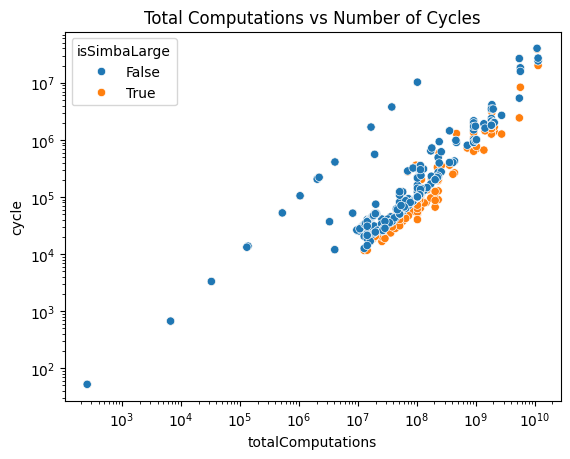

In [43]:
sns.scatterplot(df, x='totalComputations', y='cycle', hue='isSimbaLarge')
plt.title('Total Computations vs Number of Cycles')
plt.yscale('log')
plt.xscale('log')
plt.show()

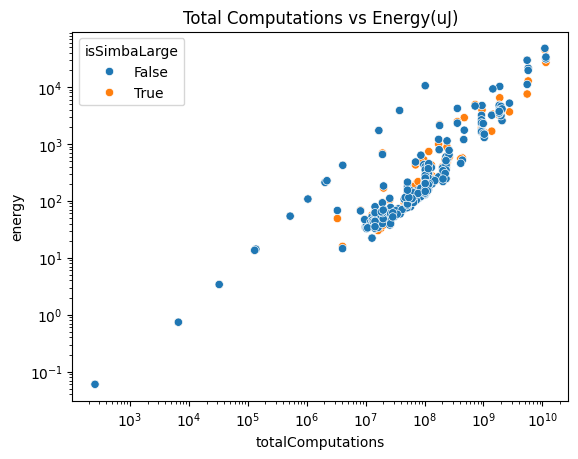

In [44]:
sns.scatterplot(df, x='totalComputations', y='energy', hue='isSimbaLarge')
plt.title('Total Computations vs Energy(uJ)')
plt.yscale('log')
plt.xscale('log')
plt.show()

In [45]:
# sns.scatterplot(df, x='totalComputations', y='cycle', hue='problemName')
# plt.yscale('log')
# plt.xscale('log')
# plt.legend().set_visible(False)
# plt.show()

We see that total factors doesn't really affect solving time, overall it looks quite random. However, we do see that time for Simba Large is significantly higher than time for Simba. This may be due to the reasoning below

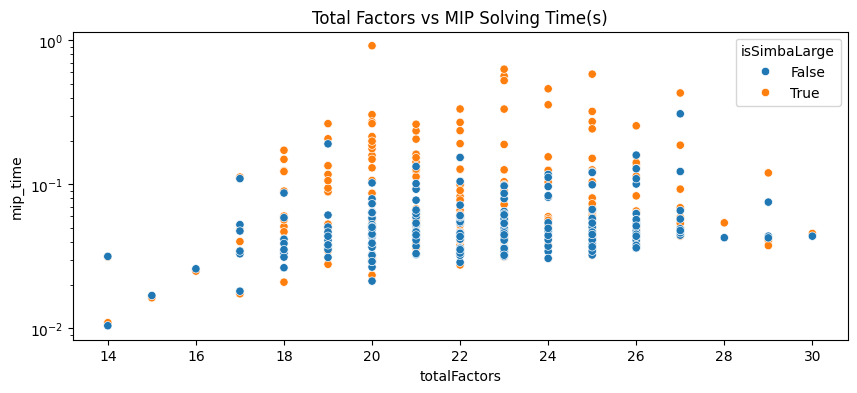

In [67]:
# Note this correlates with the size of the X matrix
plt.figure(figsize=(10, 4))
sns.scatterplot(df, x='totalFactors', y='mip_time', hue="isSimbaLarge")
plt.title('Total Factors vs MIP Solving Time(s)')
plt.yscale('log')
plt.show()

Text(0.5, 1.0, 'Total Outer Cycles(GB and DRAM) vs MIP Solving Time(s)')

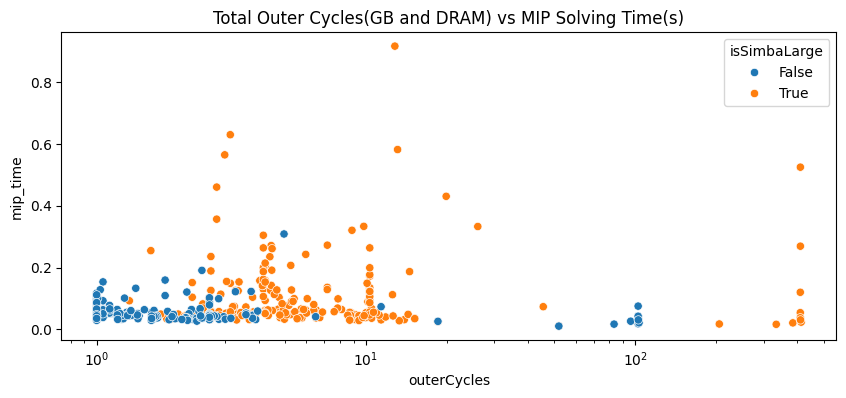

In [ ]:
# This doesn't really correlate with anything, just mostly with the number of temporal factors in the outer memory levels.
# theoretically, it shouldn't affect solving time much.

# This doesn't make sense anymore, based on what we know about pe_cycles vs cycles now
plt.figure(figsize=(10, 4))
sns.scatterplot(df, x='outerCycles', y='mip_time', hue="isSimbaLarge")
plt.xscale('log')
plt.title('Total Outer Cycles(GB and DRAM) vs MIP Solving Time(s)')

To think about why Simba Large may take longer, we need to think about the constraints, and not the objective I think. Also, about how the relaxed solution may look

The relaxed solution, you would just be able to partially schedule a factor for temporal and partially for spatial execution, so any kinda combinations of factors would work I think, and then you have to branch to try integer values.

I think eg. if you branch and you're trying to spatially schedule some stuff already, then the LP relaxation can't have more >0 values for simba. If you have simba large, you just have more stuff you could spatially schedule and you have to keep searching. That might contribute to the slightly longer solving time

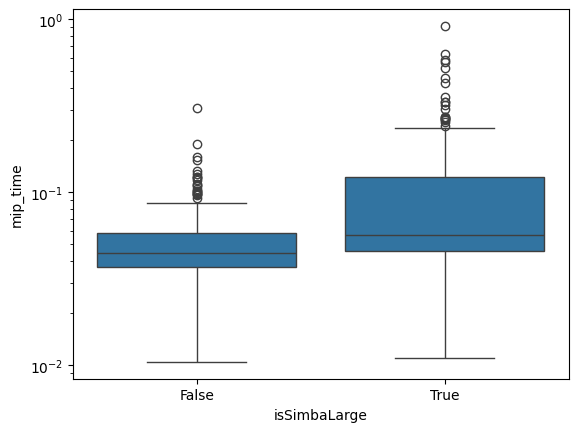

In [61]:
# Simba Large has more potential for spatial scheduling
sns.boxplot(df, x='isSimbaLarge', y='mip_time')
plt.yscale('log')
plt.show()

I think since CoSA finds efficient schedules so it's kinda maxing out buffer utilization and minimizing temporal cycles, it makes sense that total computations is related linearly to number of cycles in the efficient schedules

Note that(from work below) number of PE cycles = multiply all factors scheduled for temporal execution together

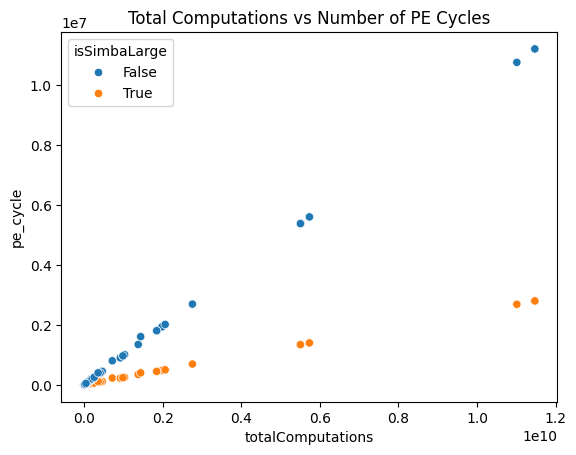

In [90]:
sns.scatterplot(df, x='totalComputations', y='pe_cycle', hue='isSimbaLarge')
plt.title('Total Computations vs Number of PE Cycles')
# plt.yscale('log')
# plt.xscale('log')
plt.show()

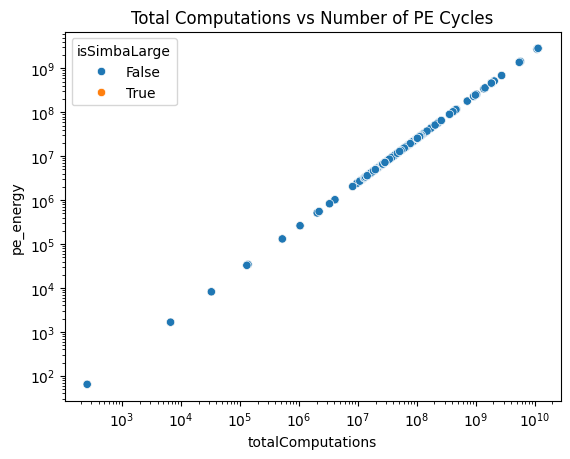

In [91]:
sns.scatterplot(df, x='totalComputations', y='pe_energy', hue='isSimbaLarge')
plt.title('Total Computations vs Number of PE Cycles')
plt.yscale('log')
plt.xscale('log')
plt.show()

In [63]:
df.columns

Index(['mem_instances', 'mem_entries', 'problem', 'prime_factors',
       'factor_config', 'spatial_config', 'prob_path', 'arch_path', 'mip_time',
       'run_status', 'cycle_results', 'utilized_capacity', 'output_dir',
       'pe_cycle', 'pe_energy', 'energy', 'cycle', 'isSimbaLarge',
       'totalComputations', 'totalFactors', 'problemName', 'outerCycles'],
      dtype='object')

# Inspecting a single JSON

In [69]:
test = all_jsons[0]
print(test['prime_factors'])
print(test['factor_config'])
print(test['spatial_config'])

[[1], [1], [7], [7], [2, 2, 2, 2, 2, 3, 11], [2, 2, 2, 2, 2, 2, 3], [1]]
[[5], [5], [0], [4], [1, 1, 1, 5, 1, 4, 1], [1, 1, 3, 3, 1, 3, 4], [5]]
[[0], [0], [0], [1], [0, 0, 1, 0, 0, 1, 0], [1, 0, 1, 1, 1, 1, 1], [0]]


In [70]:
def get_temporal_product(cfg):
    iters = 1
    for j in range(len(cfg['prime_factors'])):
        for n in range(len(cfg['prime_factors'][j])):
            if cfg['spatial_config'][j][n] == 0:
                iters *= cfg['prime_factors'][j][n]
    return iters

In [73]:
print(f'Temporal product = {get_temporal_product(test)}')
print(f'PE_cycles = {test["pe_cycle"]}')

Temporal product = 2464
PE_cycles = 2464


In [76]:
print(multiply_nested_list(test['prime_factors']))
print(test['cycle'])

9934848
25450


In [72]:
test

{'mem_instances': [4096, 512, 512, 64, 1, 1],
 'mem_entries': [1, 64, 16384, 4096, 65536],
 'problem': {'C': 1056,
  'Hdilation': 1,
  'Hstride': 1,
  'K': 192,
  'N': 1,
  'P': 7,
  'Q': 7,
  'R': 1,
  'S': 1,
  'Wdilation': 1,
  'Wstride': 1,
  'shape': 'cnn-layer'},
 'prime_factors': [[1],
  [1],
  [7],
  [7],
  [2, 2, 2, 2, 2, 3, 11],
  [2, 2, 2, 2, 2, 2, 3],
  [1]],
 'factor_config': [[5],
  [5],
  [0],
  [4],
  [1, 1, 1, 5, 1, 4, 1],
  [1, 1, 3, 3, 1, 3, 4],
  [5]],
 'spatial_config': [[0],
  [0],
  [0],
  [1],
  [0, 0, 1, 0, 0, 1, 0],
  [1, 0, 1, 1, 1, 1, 1],
  [0]],
 'prob_path': '/home/wangke61/Documents/cosa/src/cosa/configs/workloads/densenet161_graph/_outputs_input.340.yaml',
 'arch_path': '/home/wangke61/Documents/cosa/src/cosa/configs/arch/simba_large.yaml',
 'mip_time': 0.13488268852233887,
 'run_status': [1, -1, -1],
 'cycle_results': [-1, -1, -1, -1, -1, -1],
 'utilized_capacity': [1, 56, 1408, 1232, 35280, 263904],
 'output_dir': '/home/wangke61/Documents/cosa/src/out

In [92]:
def get_buffer_utilization(obj):
    lst = []
    for i in range(len(obj['mem_entries'])):
        lst.append(obj['utilized_capacity'][i] / obj['mem_entries'][i])
    return lst

In [96]:
buf_utilization = pd.DataFrame([get_buffer_utilization(t) for t in all_jsons], columns=['Register', 'AccBuf', 'WBuf', 'InputBuf', 'GlobalBuf'])

Text(0.5, 1.0, 'Boxplot of Buffer Utilization')

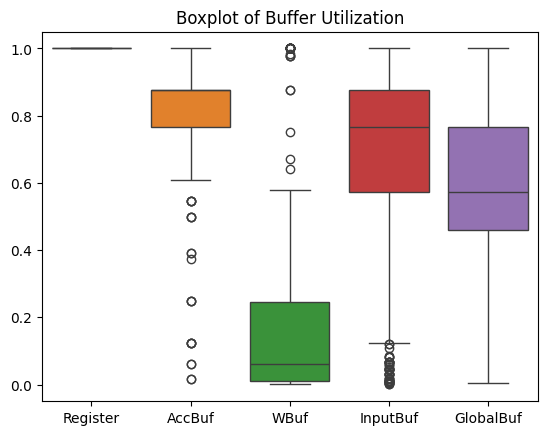

In [102]:
sns.boxplot(buf_utilization)
plt.title('Boxplot of Buffer Utilization')